## Evolution of Maxwell's equations

1D Maxwell equations for a plane wave in vacuum propagating through dark matter particle modelled by Schwarzchild interior solution under Lorenz gauge:

\begin{equation}
    \partial_{tt} \phi = (1 + 2 \alpha)^{-1} \left[ (1 - 2 \alpha) \partial_{xx} \phi - \alpha_{,xx} \phi  + 2 \alpha_{,x} ( \partial_t A^x - \partial_x \phi)  + 4 \pi (\rho + 3P)\phi  \right],
\end{equation}

\begin{equation}
    \partial_{tt} A^x = (1 + 2 \alpha)^{-1} \left[ (1 - 2 \alpha) \partial_{xx} A^x + \alpha_{,xx} A^x + 2 \alpha_{,x}( \partial_t \phi + \partial_x A^x) - 4 \pi (\rho - P)A^x \right].
\end{equation}

These equations can be converted into first order exact differential equation in time using the Method of Lines with the following substitutions:

\begin{equation}
    d_t \phi = \mu,
\end{equation}

\begin{equation}
    d_t \mu = (1 + 2 \alpha)^{-1} \left[ (1 - 2 \alpha) d_{xx} \phi - \alpha_{,xx} \phi \\ + 2 \alpha_{,x} ( d_t A^x - d_x \phi)  + 4 \pi (\rho + 3P)\phi  \right],
\end{equation}

\begin{equation}
    d_t A^x = \nu,
\end{equation}

\begin{equation}
    d_t \nu = (1 + 2 \alpha)^{-1} \left[ (1 - 2 \alpha) d_{xx} A^x + \alpha_{,xx} A^x \\ + 2 \alpha_{,x}( d_t \phi + d_x A^x) - 4 \pi (\rho - P)A^x \right].
\end{equation}

Thus the evolution variables are now $\{\phi,\mu,A^x,\nu\}$ which can be evolved with discretization in time using Runge-Kutta methods.





In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def compute_dt(cf,dx,c):
    dt = (cf*dx)/c
    return dt

##----------------------------Second order finite difference method--------------------------------##
def second_derivative_CFD2(var,dx):
    D2_var = np.zeros(len(var))
    var_with_ghosts = exterior_points_CFD2(var)
    for i in range (1,len(var_with_ghosts)-1): # calculates only interior
        # Central finite difference method:
        D2_var[i-1] = (var_with_ghosts[i-1] - 2*var_with_ghosts[i] + var_with_ghosts[i+1])/dx**2
    return D2_var

def exterior_points_CFD2(var):
    var_left_ghost = np.append(var[len(var)-1],var)
    var_ghosts = np.append(var_left_ghost,var[0])
    return var_ghosts

##----------------------------Fourth order finite difference method--------------------------------##
#Ref: https://www.mech.kth.se/~ardeshir/courses/literature/fd.pdf
def second_derivative_CFD4(var,dx):
    D2_var = np.zeros(Nx)
    var_with_ghosts = exterior_points_CFD4(var)
    for i in range (2,len(var_with_ghosts)-2):
        # Central finite difference method:
        D2_var[i-2] = (-var_with_ghosts[i+2] + 16*var_with_ghosts[i+1] - 30*var_with_ghosts[i]
                       + 16*var_with_ghosts[i-1] - var_with_ghosts[i-2]  )/(12*dx**2)
    return D2_var

def first_derivative_CFD4(var,dx):
    D1_var = np.zeros(Nx)
    var_with_ghosts = exterior_points_CFD4(var)
    for i in range (2,len(var_with_ghosts)-2):
        # Central finite difference method:
        D1_var[i-2] = (-var_with_ghosts[i+2] + 8*var_with_ghosts[i+1] -8*var_with_ghosts[i-1]
                       - var_with_ghosts[i-2]  )/(12*dx)
    return D1_var

#For Periodic Boundaries
# def exterior_points_CFD4(var): 
#     var_l1_ghost = np.append(var[len(var)-1],var)
#     var_l2_ghost = np.append(var[len(var)-2],var_l1_ghost)
#     var_r1_ghost = np.append(var_l2_ghost,var[0])
#     var_r2_ghost = np.append(var_r1_ghost,var[1])
#     var_ghosts = var_r2_ghost
#     return var_ghosts

#For Non-Periodic Boundaries
def exterior_points_CFD4(var): 
    var_l1_ghost = np.append(0,var)
    var_l2_ghost = np.append(0,var_l1_ghost)
    var_r1_ghost = np.append(var_l2_ghost,0)
    var_r2_ghost = np.append(var_r1_ghost,0)
    var_ghosts = var_r2_ghost
    return var_ghosts

In [3]:
##------------Explicit Time integrators------------------------------##

def RK2(rhs,u_n,dt):
    k1 = np.array(rhs(u_n))
    k2 = np.array(rhs(u_n + (dt/2)*k1))
    u_np1 = u_n + dt*k2
    return u_np1

def RK4(rhs,u_n,dt):
    k1 = np.array(rhs(u_n))
    k2 = np.array(rhs(u_n + (dt/2)*k1))
    k3 = np.array(rhs(u_n + (dt/2)*k2))
    k4 = np.array(rhs(u_n + dt*k3))
    u_np1 = u_n + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
    return u_np1

In [4]:
def numerical_method_flags(time_integration_method,finite_difference_method):
    global FD_method,TI_method, RHS_func
    if (finite_difference_method == "CFD2"):
        FD_method = second_derivative_CFD2
    if (finite_difference_method == "4O_CFD2"):
        FD_method = second_derivative_CFD4
    if (finite_difference_method == "4O_CFD1"):
        FD_method = first_derivative_CFD4
    if (time_integration_method == "RK2"):
        TI_method = RK2
        RHS_func = lambda u_n,FD_method,dx: (scalar_wave_RHS_f(u_n,FD_method,dx))
    if (time_integration_method == "RK4"):
        TI_method = RK4
        RHS_func = lambda u_n,FD_method,dx: (scalar_wave_RHS_f(u_n,FD_method,dx))

In [5]:
def Evolve(init,rhs,time_integration_method,Nt,dt):
    global comp_time
    u_0 = init()
    u_result = np.zeros((Nt,len(u_0),Nx)) #u_result[i][j][k]; i -> time, j-> variable, k-> x position
    print("Total iteration = %d"%(Nt-1))
    start_time = time.time()
    u_result[0] = np.array((u_0))
    for i in range (1,Nt):
        u_np1 = np.array(time_integration_method(rhs,u_0,dt))
        #store result of iteration
        u_result[i] = u_np1
        u_result[i][0] = init()[0] #this is for x coordinate
        #update values
        u_0 = u_np1
        u_0[0] = var_x_4h #this is for x coordinate
    end_time = time.time()
    comp_time = end_time - start_time
    print("Computation time: %f seconds"%(comp_time))
    return u_result

In [6]:
#RHS expressions

#Note: Split the RHS terms into two parts.
#      Non-stiff terms are defined in "scalar_wave_RHS_f" rountine and
#      stiff terms are defined in "scalar_wave_RHS_g" routine.

alpha_ext = lambda x: M/np.sqrt(x**2) #should be inside abs
alpha_int = lambda x: 0.5*(M/a_ext)*(3 - (np.sqrt(x**2)/a_ext)**2)
Dx_alpha_ext = lambda x: -M/np.sqrt(x**2)**2
Dxx_alpha_ext = lambda x: M/np.sqrt(x**2)**3
Dx_alpha_int = lambda x: -M*np.sqrt(x**2)/a_ext**3
Dxx_alpha_int = lambda x: -M/a_ext**3



# Index data:    var_x= u_n[0] phi = u_n[1],mu = u_n[2], Ax = u_n[3], nu = u_n[4]
def scalar_wave_RHS_f(u_n,second_derivative,dx):
    x = u_n[0]
    phi = u_n[1]
    mu = u_n[2]
    Ax = u_n[3]
    nu = u_n[4]
    Dxx_phi = second_derivative(phi,dx)
    Dxx_Ax = second_derivative(Ax,dx)
    Dx_phi = first_derivative_CFD4(phi,dx)
    Dx_Ax = first_derivative_CFD4(Ax,dx)

    phi_dot = mu
    Ax_dot = nu
    mu_dot = np.zeros(len(x))
    nu_dot = np.zeros(len(x))
    for i in range (len(x)):
        if (np.abs(x[i]) > a_ext):
            alpha = alpha_ext(x[i])
            Dx_alpha = Dx_alpha_ext(x[i])
            Dxx_alpha = Dxx_alpha_ext(x[i])
            rho = 0
            P = 0
        if (np.abs(x[i]) <= a_ext):
            alpha = alpha_int(x[i])
            Dx_alpha = Dx_alpha_int(x[i])
            Dxx_alpha = Dxx_alpha_int(x[i])
            rho = rho_int
            P = ( constA*(constC**(-2) - 2*np.sqrt(x[i]**2)**2 ) + constB*((np.sqrt(x[i]**2)*constC)**2 - 2) )/( 8*np.pi*R2*(constA*np.sqrt(x[i]**2)**2 + constB) )            
        
        mu_dot[i] = (1/(1 + 2*alpha))*( (1-2*alpha)*Dxx_phi[i] 
                                        - Dxx_alpha*phi[i] + 2*Dx_alpha*(nu[i]- Dx_phi[i])
                                        + 4*np.pi*phi[i]*(rho + 3*P) )
        nu_dot[i] = (1/(1 + 2*alpha))*( (1-2*alpha)*Dxx_Ax[i] 
                                        + Dxx_alpha*Ax[i] + 2*Dx_alpha*(mu[i] + Dx_Ax[i])
                                        - 4*np.pi*Ax[i]*(rho - P)  )
                    
    u_rhs_f = np.array((x,phi_dot,mu_dot,Ax_dot,nu_dot))
    return u_rhs_f

In [7]:
# Index data:     var_x = u_n[0] phi = u_n[1],mu = u_n[2], Ax = u_n[3], nu = u_n[4]
def initial_conditions(var_x):
    var_phi = init_phi(var_x)
    var_mu = init_mu(var_x)
    var_Ax = init_Ax(var_x)
    var_nu = init_nu(var_x)
    return np.array([var_x,var_phi,var_mu,var_Ax,var_nu])


init_phi = lambda x: np.exp(-((x+0.5)/0.02)**2)
#Initial condition for (d/dt)phi = mu at t=0
init_mu = lambda x: x*0
init_Ax = lambda x: np.exp(-((x+0.5)/0.02)**2)
#Initial condition for (d/dt)Ax = mu at t=0
init_nu = lambda x: x*0

#Physics
x_start = -1.0
x_length = 2.0
t_start = 0.0
t_end = 1.0

M = 0.0001
a_ext = 0.1
constC = np.sqrt(M/(2*a_ext**3))
constA = constC*(4*a_ext - M)/(2*a_ext +M)
constB = (1/constC)*(2*a_ext - 2*M)/(2*a_ext + M)
rho_int = (3*M)/((4*np.pi*a_ext**3)*(1 + M/(2*a_ext))**6)
R2 = 3/(8*np.pi*rho_int)

In [8]:
#Specify available time integration method:
#- Explicit: 'RK2' or 'RK4',
#- Implicit-Explicit: 'IMEX-midpoint(1,2,2)' or 'IMEX-ARS(3,4,3)'

# Specify available Finite Difference method: 
#- Central Finite Difference: 'CFD2' or '4O_CFD2'

time_integration_method = "RK4" 
finite_difference_method = "4O_CFD2" 
numerical_method_flags(time_integration_method,finite_difference_method)

#CFL condition: dt < alpha*dx/c
Courant_factor = 0.5
Nx = 500

In [9]:
def set_grid(N,start,length,str):
    end = start + length
    dx = (end - start)/N # or (N-1) #this includes end points
    var = np.zeros(N)
    for i in range (N):
        var[i] = start + dx*i
    print("Resolution (%s) = %.4f"%(str,dx))
    print("End point = %.4f"%var[N-1])
    return var,dx

var_x_4h,dx = set_grid(Nx,x_start,x_length,"dx")
dt_4h = compute_dt(Courant_factor,dx,1.0) # wave speed of phi
var_t_4h = np.arange(t_start,t_end + dt_4h,dt_4h)
Nt_4h = len(var_t_4h)
print('Time step size = %.4f'%(dt_4h))


Resolution (dx) = 0.0040
End point = 0.9960
Time step size = 0.0020


In [10]:

#-----------------Start Numerical Simulation-------------------------------------------#

u_Nsoln_4h = Evolve(lambda: initial_conditions(var_x_4h),
                  lambda u_n: RHS_func(u_n,FD_method,dx),TI_method,Nt_4h,dt_4h)


Total iteration = 500


Computation time: 7.786278 seconds


In [11]:
#----------- End of numerical solution computation-----------------#

In [12]:
# Index data:     phi = u_n[0],mu = u_n[1],zeta = u_n[2],nu = u_n[3]
x_4h = u_Nsoln_4h[:,0]
phi_4h = u_Nsoln_4h[:,1]
Ax_4h = u_Nsoln_4h[:,3]


0


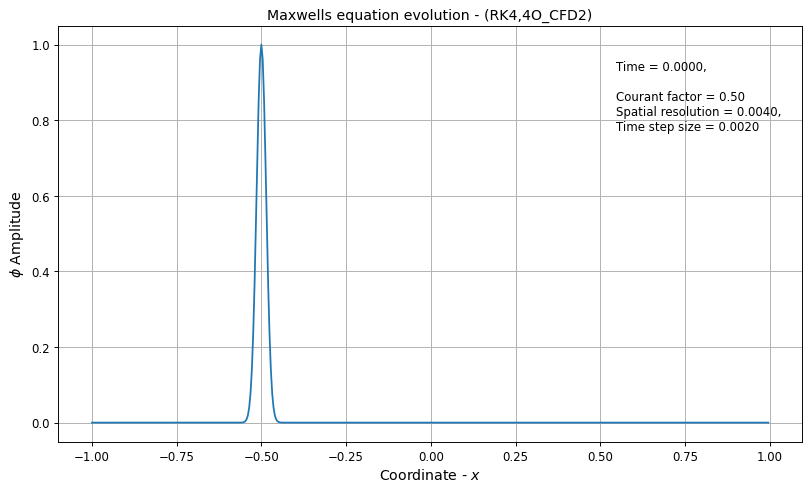

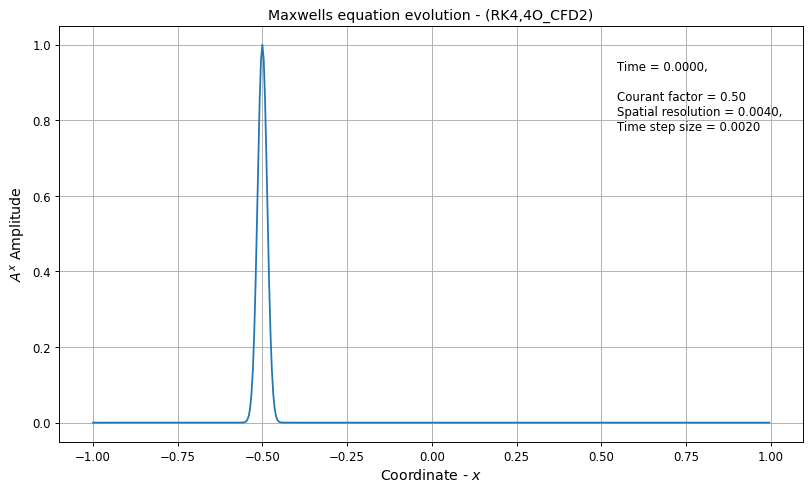

25


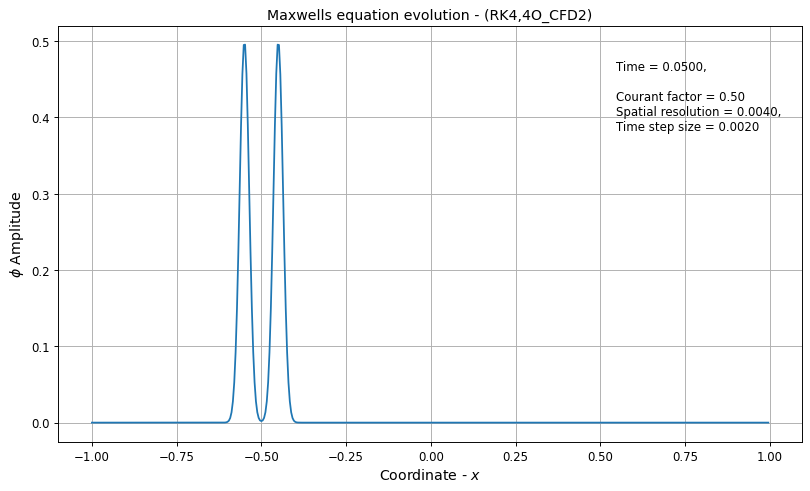

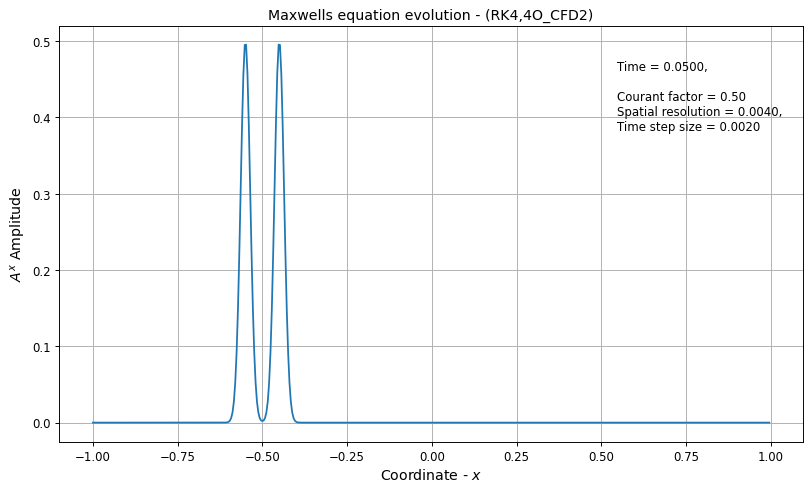

50


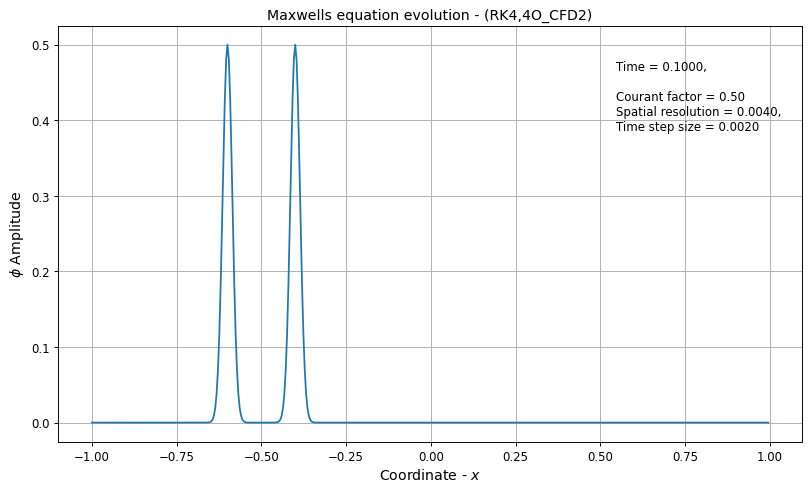

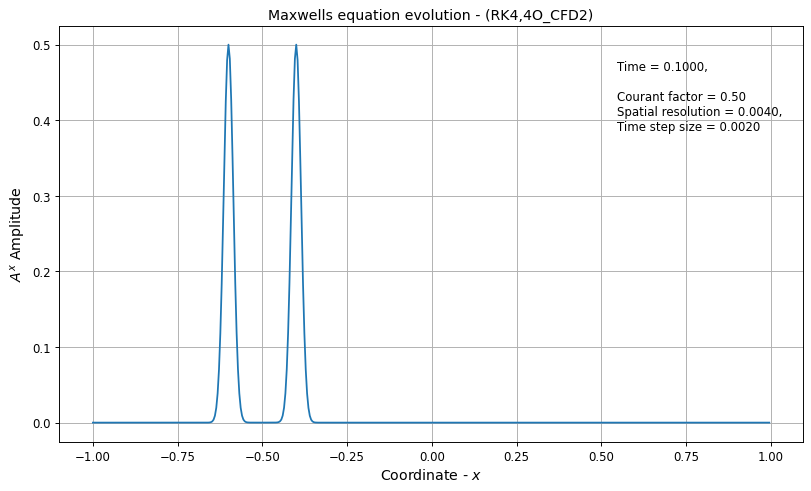

75


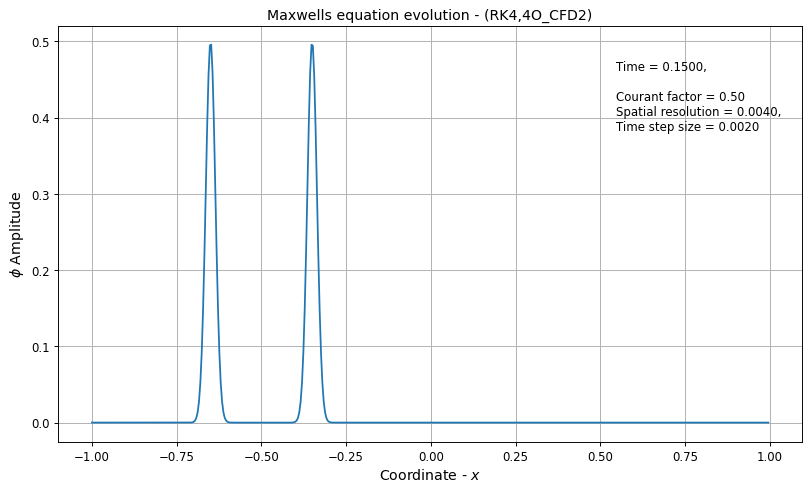

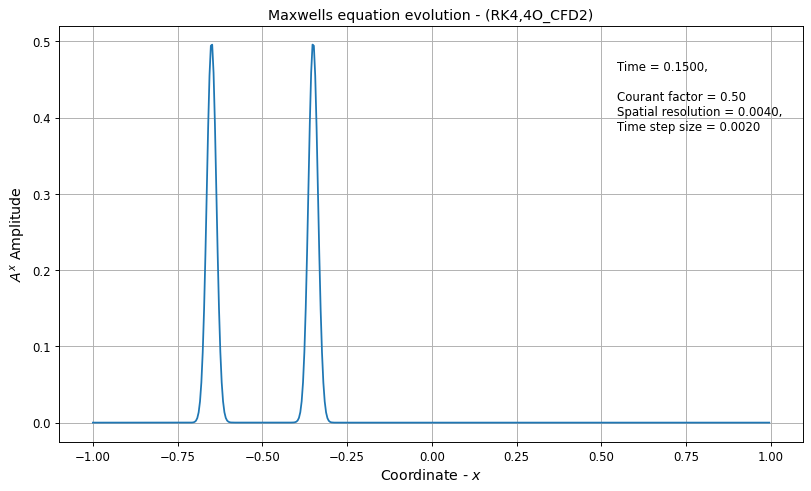

100


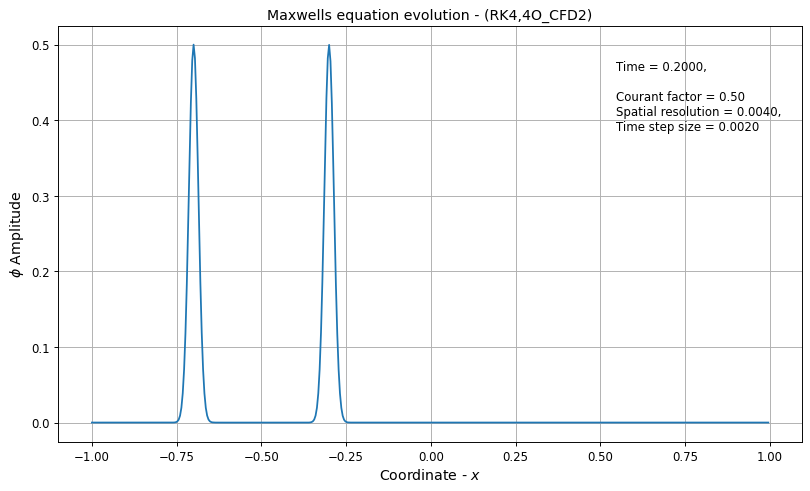

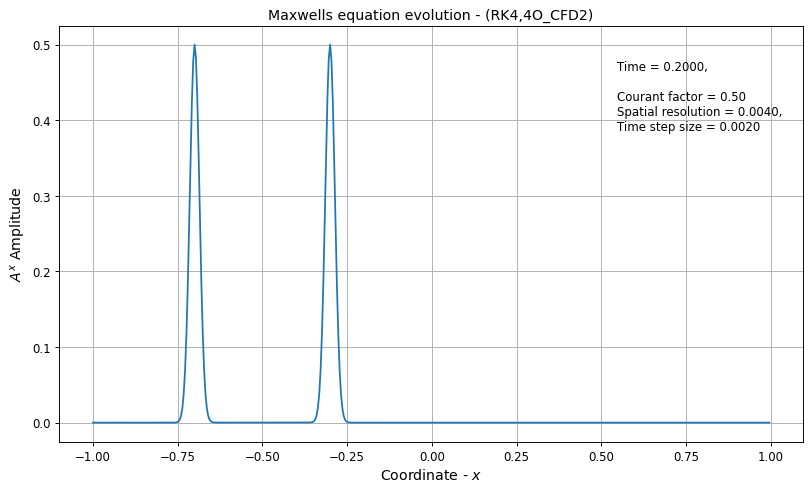

125


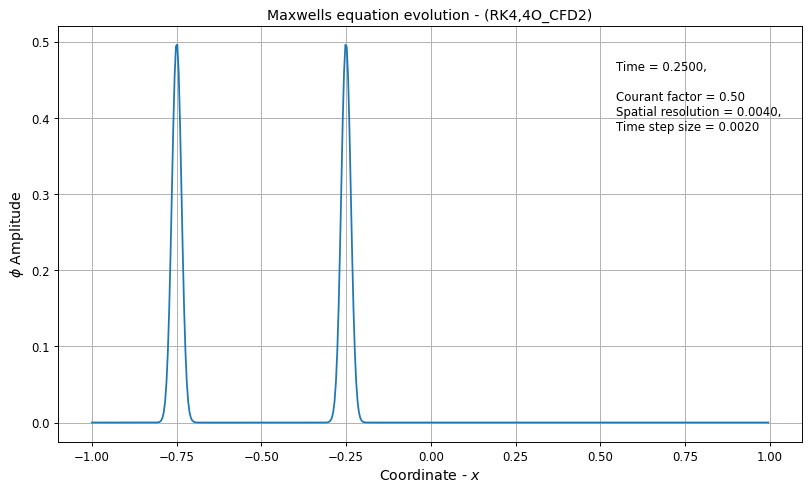

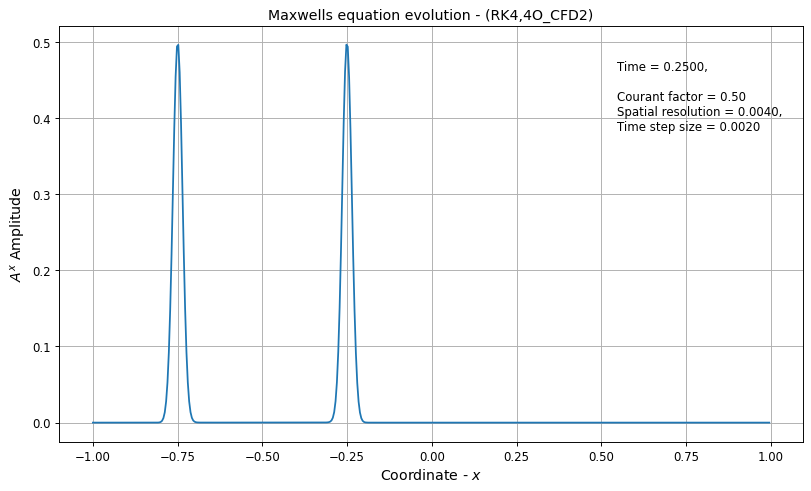

150


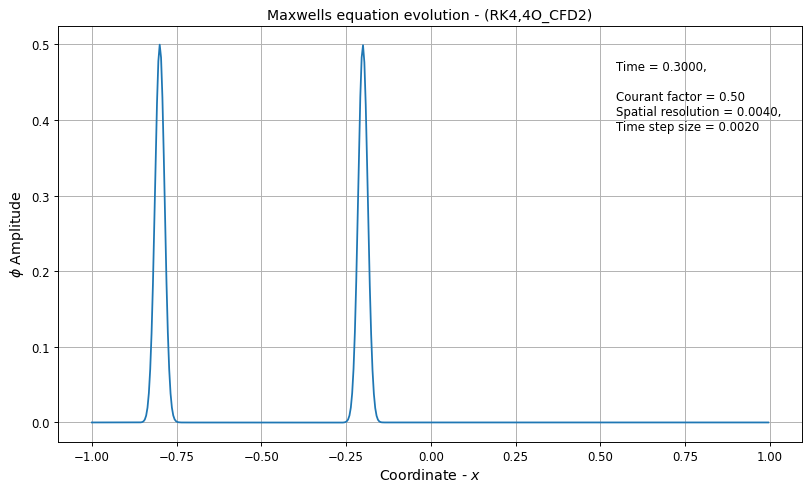

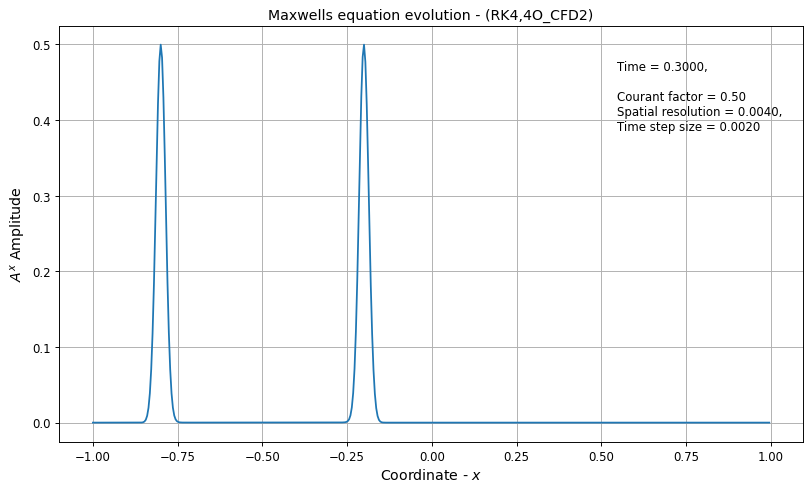

175


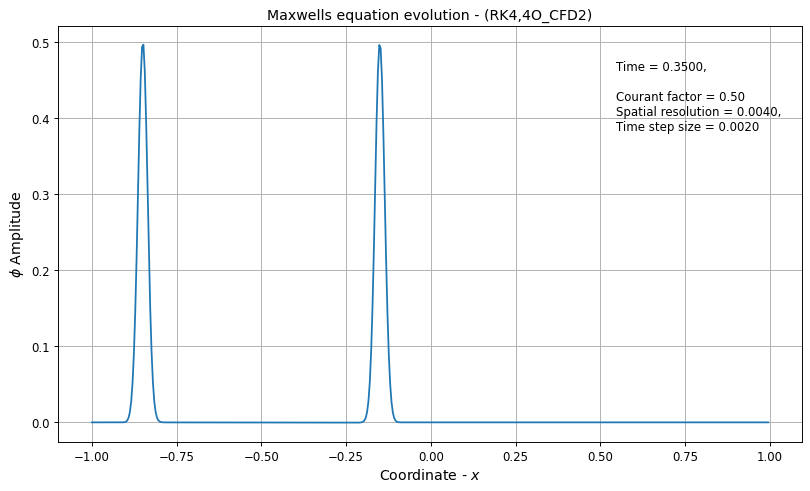

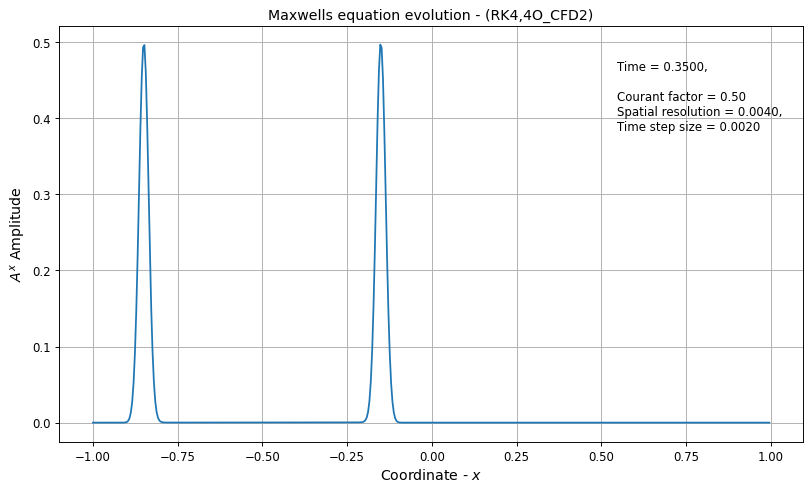

200


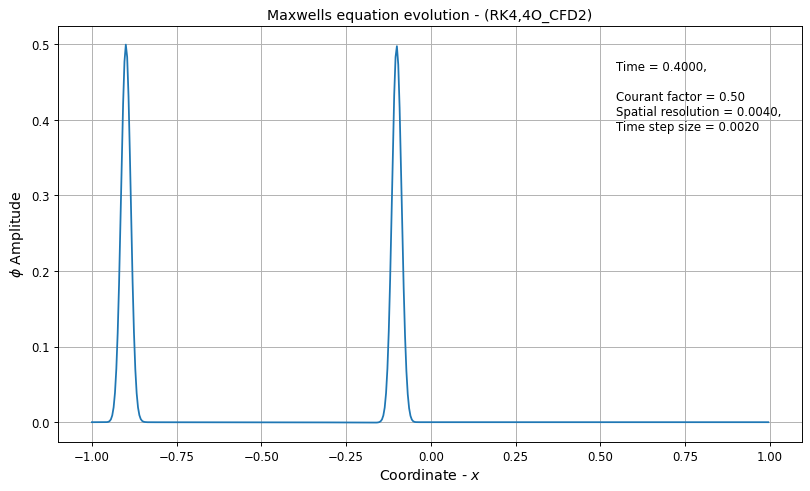

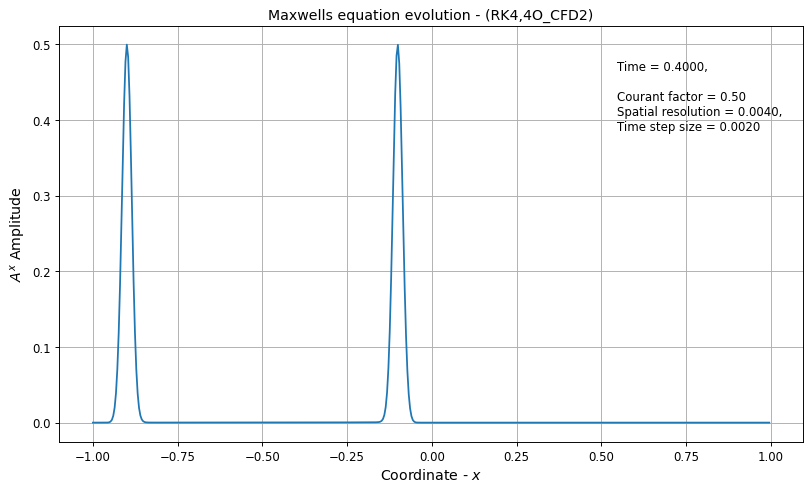

225


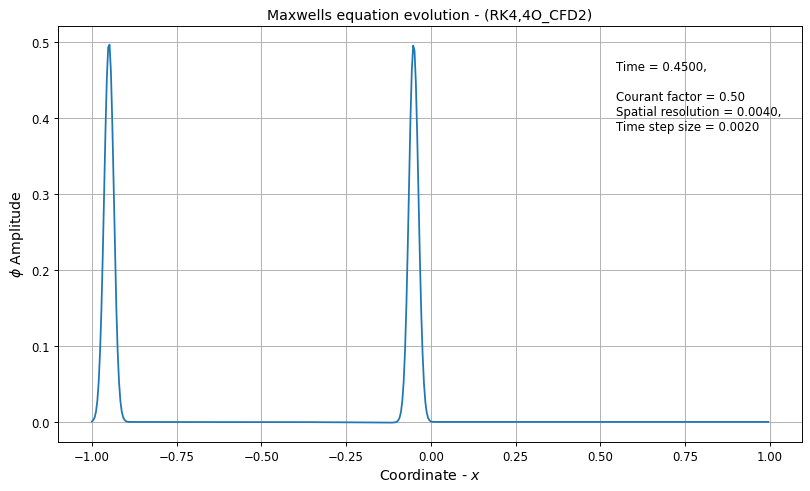

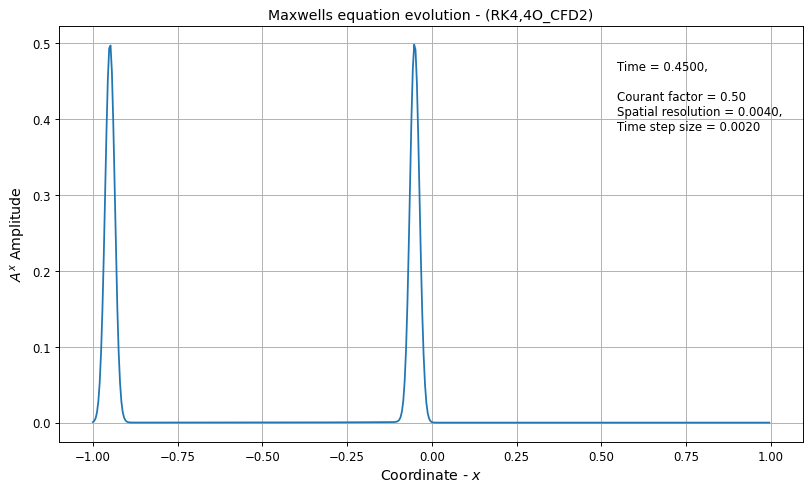

250


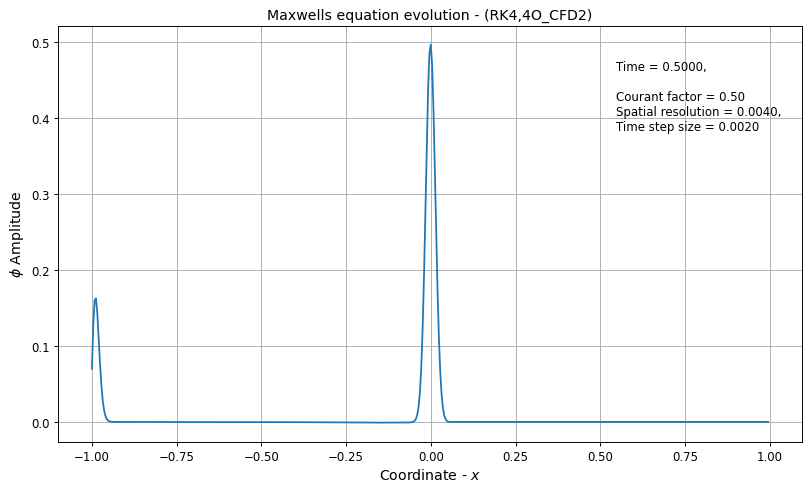

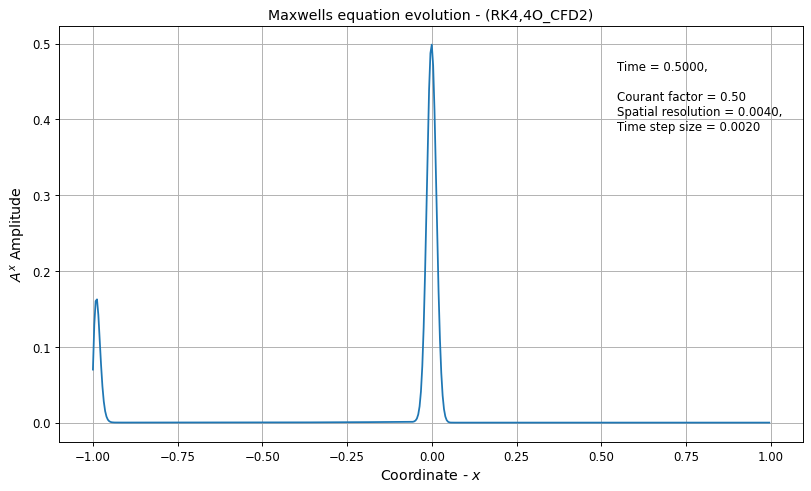

275


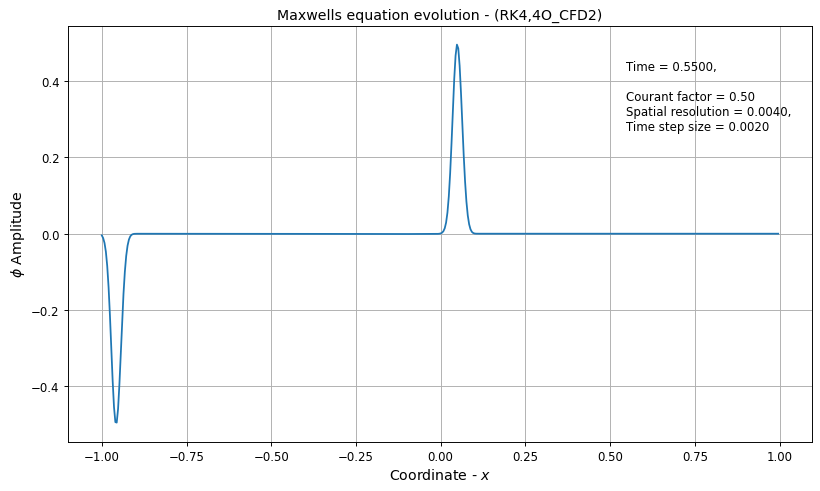

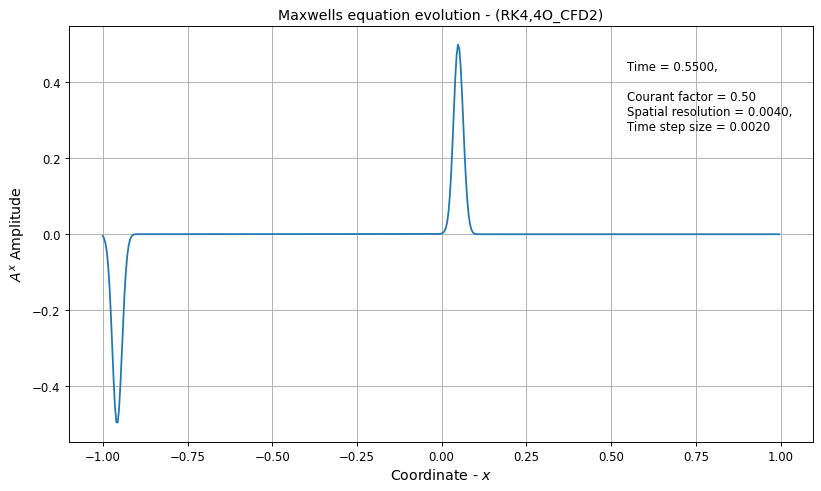

300


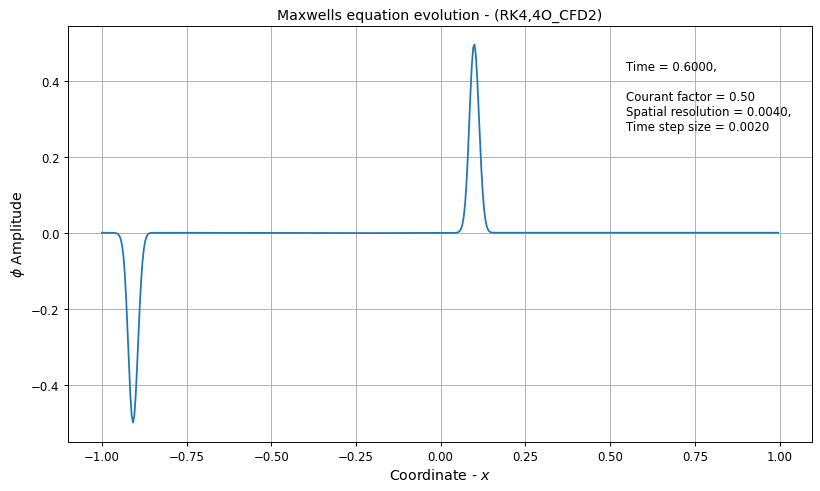

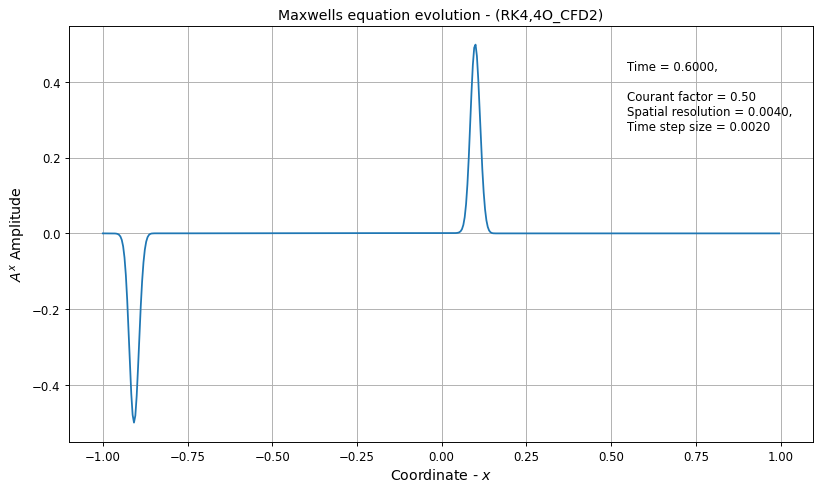

325


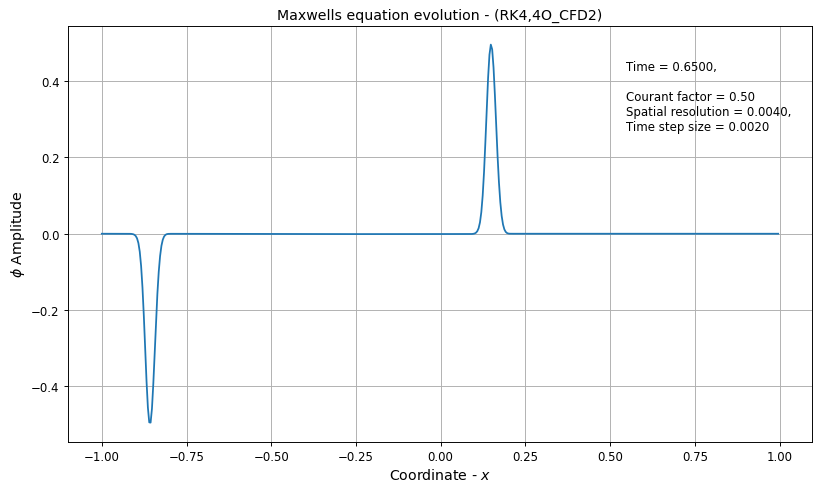

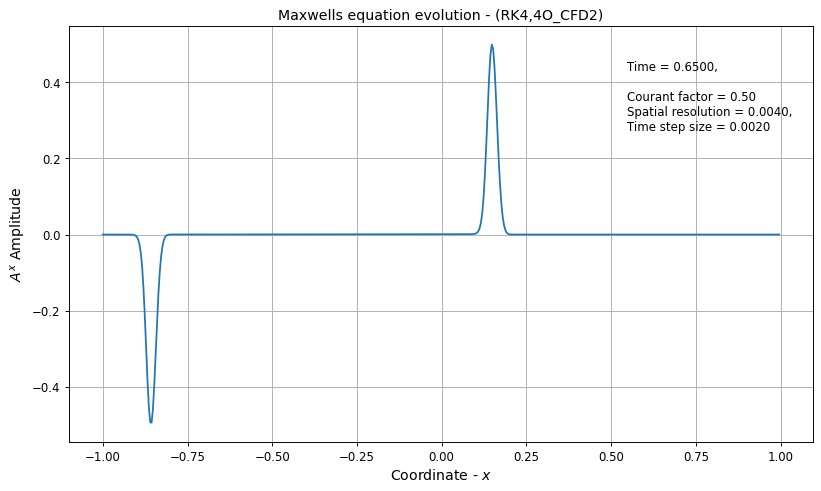

350


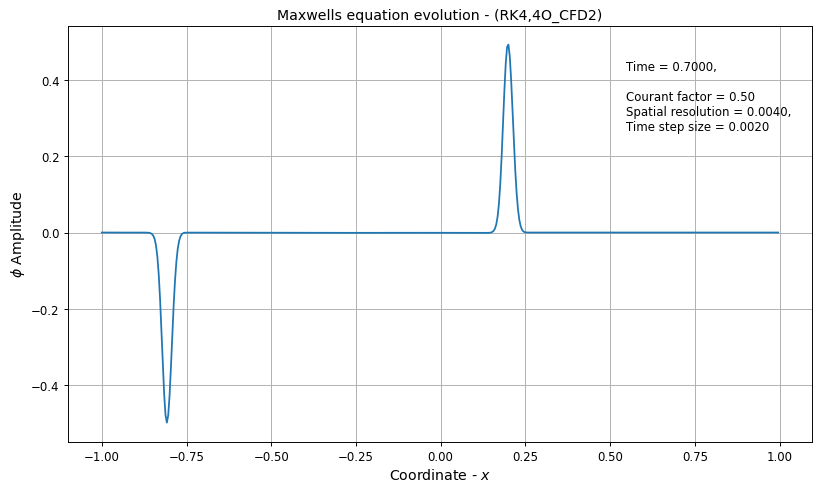

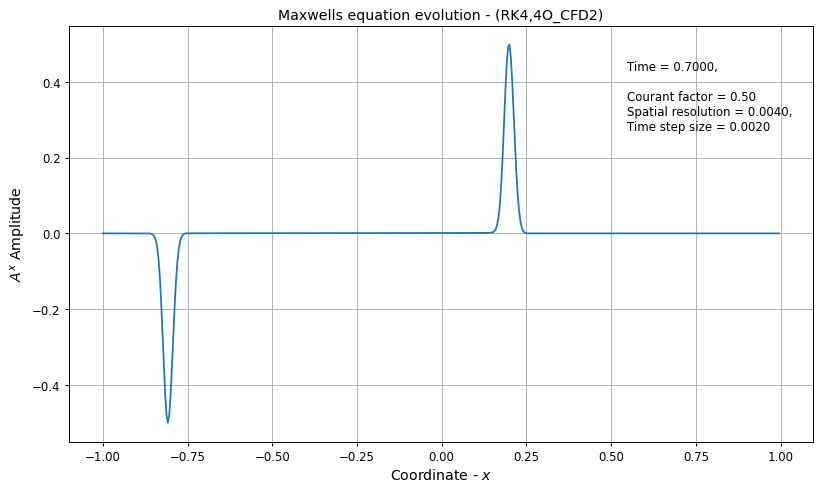

375


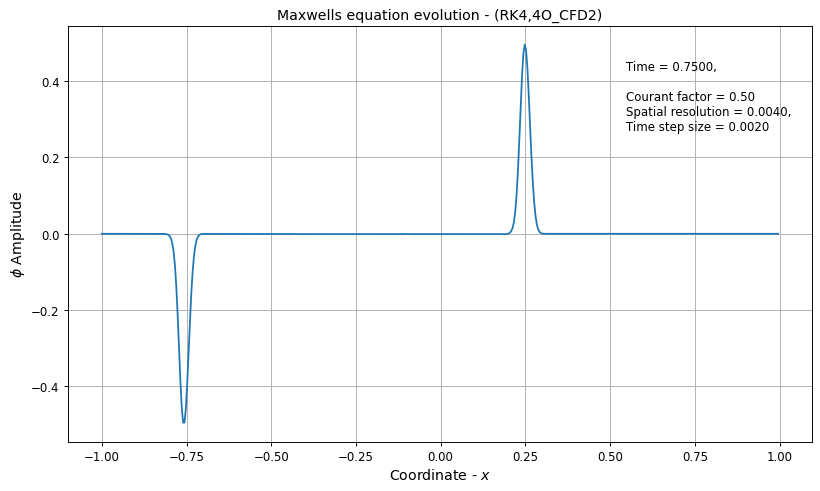

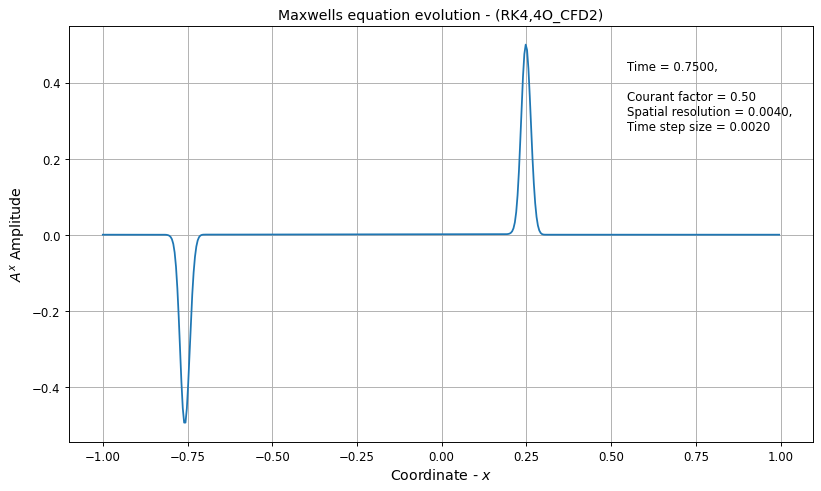

400


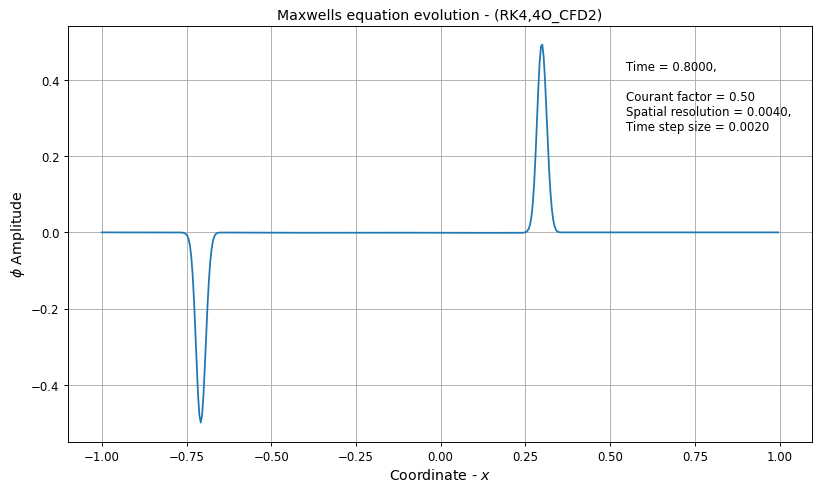

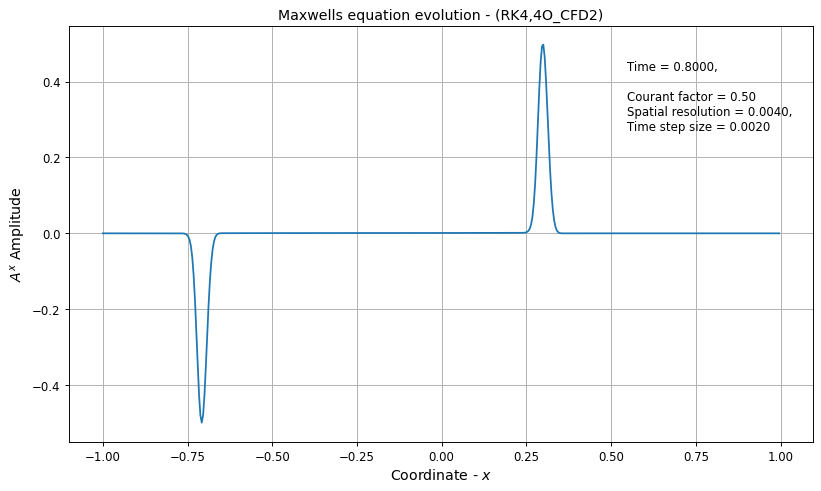

425


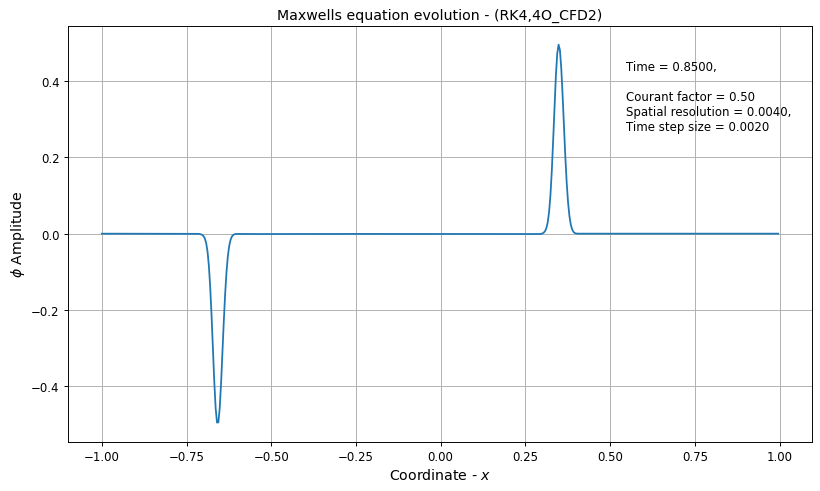

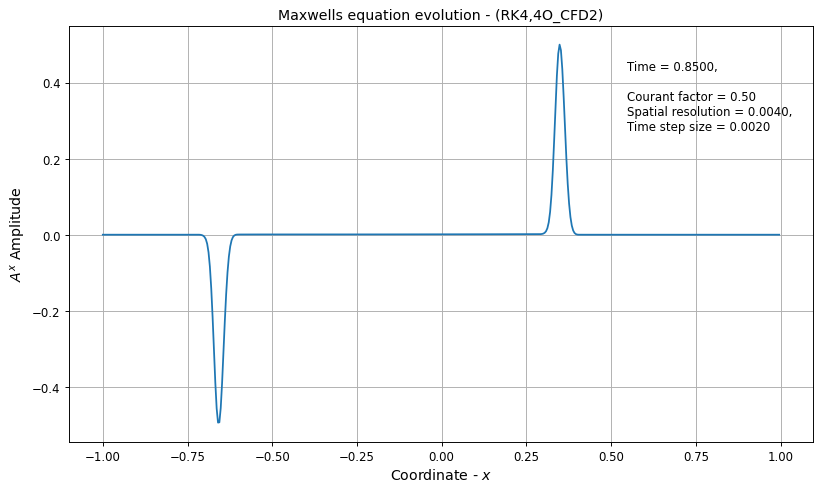

450


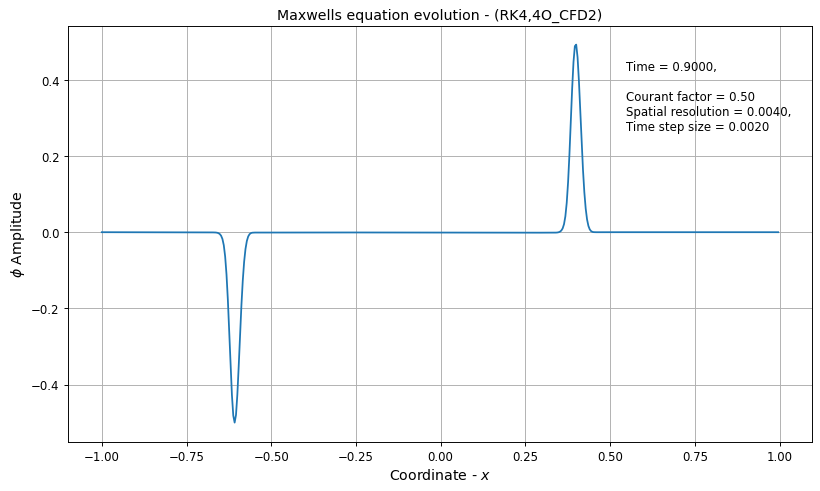

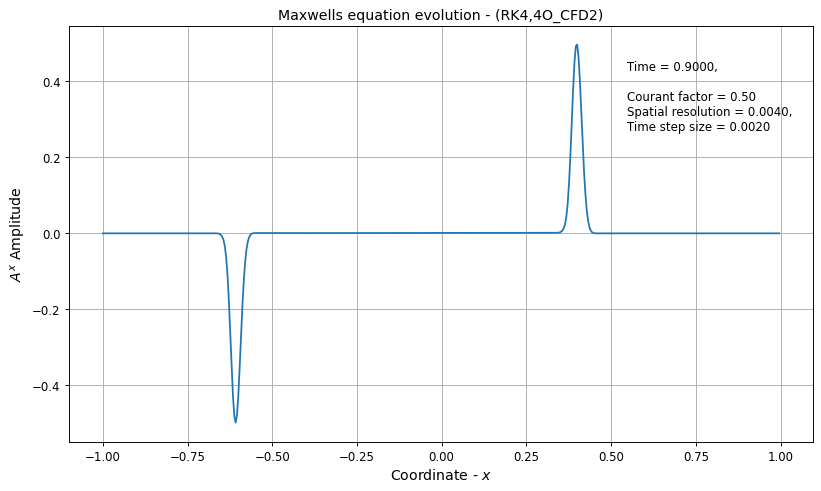

475


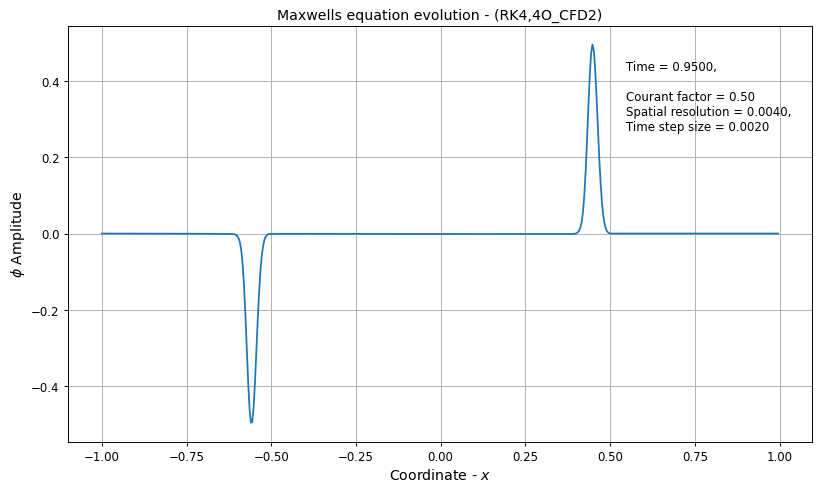

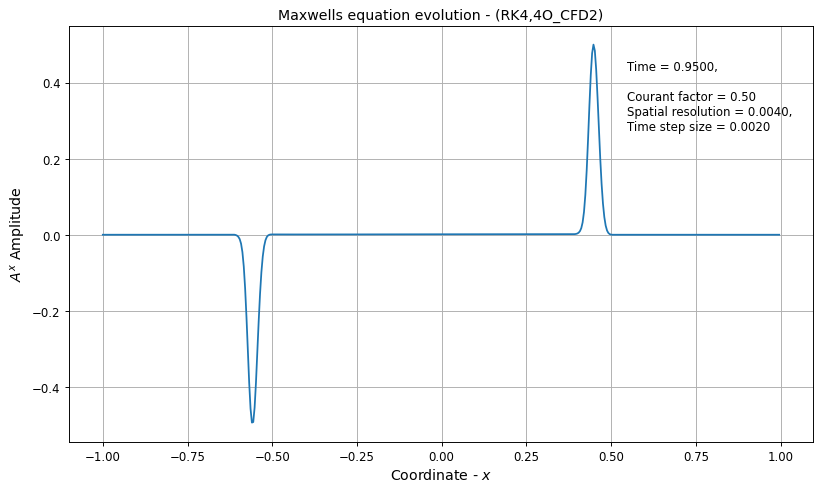

500


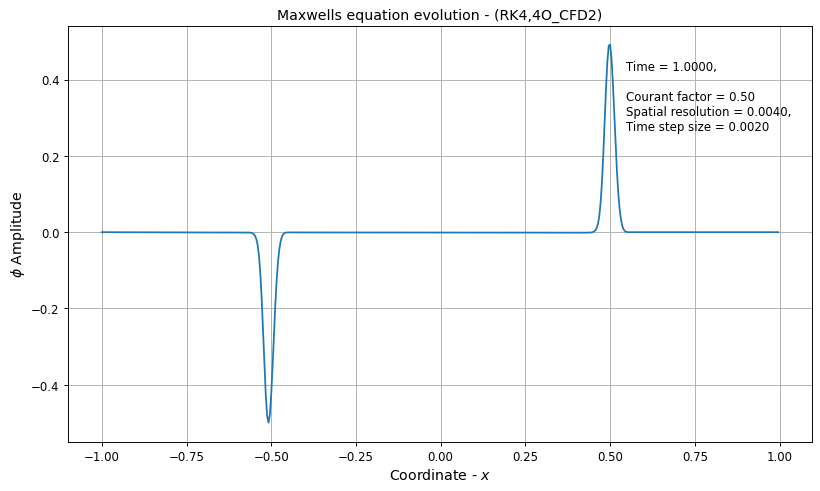

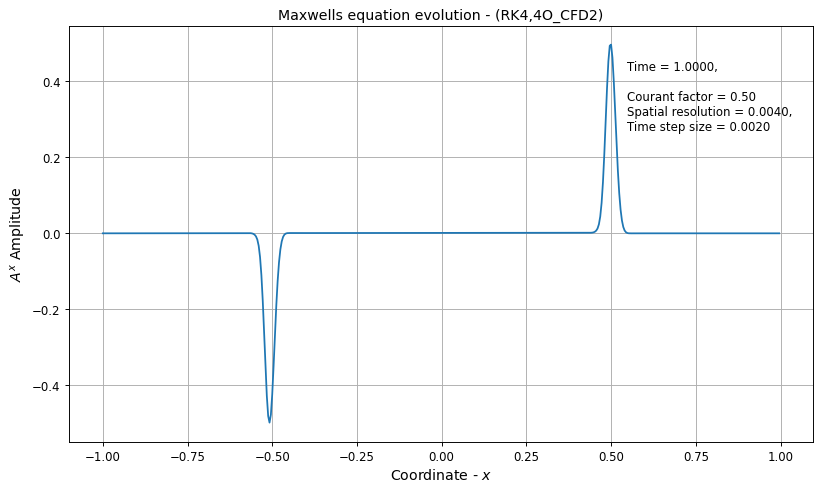

In [13]:

# Plot evolution of wave function
###-------------------------------------------------###
def plot_evolution(title,x_label,y_label,x_param,y_param1,var_t,dx,dt,i):
    fig_dpi = 85
    fig, ax = plt.subplots(figsize=(960/fig_dpi,540/fig_dpi),dpi = fig_dpi)
    plt.title(title,fontsize=12)
    plt.xlabel(x_label,fontsize=12)
    plt.ylabel(y_label,fontsize=12)
    plt.plot(x_param,y_param1,'-')
    #ax.set_ylim([-1.1, 1.1])
    plt.grid(axis="both")
    plt.text(0.75, 0.75,
             'Time = %.4f,\n\nCourant factor = %0.2f\nSpatial resolution = %.4f,\nTime step size = %.4f'
             %(var_t[i],Courant_factor,dx,dt),transform=ax.transAxes)
    plt.show()

plots_to_generate = 20
for i in range (0,Nt_4h,int(Nt_4h/plots_to_generate)):
    print(i)
    plot_evolution('Maxwells equation evolution - (%s,%s)'%(time_integration_method,finite_difference_method),
                   r'Coordinate - $x$',r'$\phi$ Amplitude',
                   var_x_4h,phi_4h[i,:],var_t_4h,dx,dt_4h,i)
    plot_evolution('Maxwells equation evolution - (%s,%s)'%(time_integration_method,finite_difference_method),
                   r'Coordinate - $x$',r'$A^x$ Amplitude',
                   var_x_4h,Ax_4h[i,:],var_t_4h,dx,dt_4h,i)
    